In [1]:
import sys 
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / 'statistics_server'))

import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet

from psql_client import PSQLClient

sql_client = PSQLClient(
	host='localhost',
	port=5432,
	user='default',
	password='12345',
	dbname='hack',
)

/home/ubuntu/lct_hack/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
spgz_name = 'Скобы для степлера'
date_grain = 'month'
sql = f"""
with dates as (
select distinct date_trunc('{ date_grain }', generate_series('2018-01-09'::date, '2023-01-01', interval '1 day')) as date
),
contracts_raw_delta as (
select 	
	spgz_name,
	date_trunc('{ date_grain }', contract_date) as contract_date,
	sum(contracts_price) as contracts_price,
	coalesce(
		age(lead(date_trunc('{ date_grain }', contract_date)) over(order by date_trunc('{ date_grain }', contract_date)), date_trunc('{date_grain }', contract_date)),
		age('2023-01-01'::date, date_trunc('{ date_grain}', contract_date))
	) as delta
from procurement_contracts_date_data
where spgz_name = '{ spgz_name }'
group by spgz_name, date_trunc('{ date_grain }', contract_date)
),
contracts as (
select 
	spgz_name,
	contract_date,
	contracts_price,
	extract(year from delta)*12 + extract(month from delta) as delta
from contracts_raw_delta
)
select 	
	'{spgz_name}' as spgz_name,
	t.date as contract_date,
	coalesce(contracts_price, 0) as contracts_price,
	coalesce(tt.delta, 0) as delta,
	case 
		when coalesce(tt.delta, 0) = 0 then 0 
		else round(coalesce(contracts_price, 0) / coalesce(tt.delta, 0), 2) 
	end as price_per_1_delta
from dates t
left join contracts tt on t.date = tt.contract_date
order by t.date
;
"""
df = sql_client.select_df(sql)
contracts_df = df[df['contracts_price'] > 0]
contracts_df

,spgz_name,contract_date,contracts_price,delta,price_per_1_delta
4,Скобы для степлера,2018-05-01 00:00:00+00:00,1334615.26,13,102662.71
17,Скобы для степлера,2019-06-01 00:00:00+00:00,393706.20,17,23159.19
34,Скобы для степлера,2020-11-01 00:00:00+00:00,452308.03,18,25128.22
52,Скобы для степлера,2022-05-01 00:00:00+00:00,1794658.14,6,299109.69
58,Скобы для степлера,2022-11-01 00:00:00+00:00,201699.25,2,100849.63


In [31]:
weights = np.array(range(1, contracts_df.shape[0]+1)) ** 5
# weights = np.ones(shape=(contracts_df.shape[0]))
avg_price_per_delta = float(np.average(contracts_df.sort_values('contract_date')['price_per_1_delta'].astype('float').values[:-1], weights=weights[:-1]))
print(avg_price_per_delta)

avg_delta = int(np.average(contracts_df.sort_values('contract_date')['delta'].astype('float').values, weights=weights))
print(avg_delta)

last_contract_price, delta_last_contract_and_current_date = contracts_df.loc[contracts_df['contract_date'] == contracts_df['contract_date'].max(), ['contracts_price', 'delta']].values[0]
print(last_contract_price, delta_last_contract_and_current_date)

costs = float(last_contract_price) - (float(avg_price_per_delta) * float(delta_last_contract_and_current_date))
delta_available = costs // avg_price_per_delta
print(delta_available)


print(avg_delta * avg_price_per_delta)

print()

avg_price_per_delta = contracts_df['price_per_1_delta'].mean()
print(avg_price_per_delta)

avg_delta = int(contracts_df['delta'].mean())
print(avg_delta)

last_contract_price, delta_last_contract_and_current_date = contracts_df.loc[contracts_df['contract_date'] == contracts_df['contract_date'].max(), ['contracts_price', 'delta']].values[0]
print(last_contract_price, delta_last_contract_and_current_date)

costs = float(last_contract_price) - (float(avg_price_per_delta) * float(delta_last_contract_and_current_date))
delta_available = costs // avg_price_per_delta
print(delta_available)

print(avg_delta * avg_price_per_delta)

240952.48985384614
3
201699.25 2
-2.0
722857.4695615384

110181.88799999999
11
201699.25 2
-1.0
1212000.768


In [ ]:
deltas = contracts_df['delta'].astype('float').values
def regularity_count(deltas):
	print(len(deltas) > 2)
	print()

def regularity_all(deltas):	
	print(deltas)
	mean_delta = np.mean(deltas)
	std_delta = np.std(deltas)
	print('mean', mean_delta)
	print('std', std_delta)
	print('regularity', std_delta / mean_delta)
	print()

def regularity_by_last(deltas, last_delta):
	print(deltas, last_delta)
	print('mean', np.mean(deltas) * 2)
	print('last', last_delta)
	print('regular last', np.mean(deltas * 2) > last_delta)

regularity_count(deltas)
regularity_all(deltas[:-1])
regularity_by_last(deltas[:-1], deltas[-1])

True

[ 1. 10.  5. 12.]
mean 7.0
std 4.301162633521313
regularity 0.614451804788759

[ 1. 10.  5. 12.] 4.0
mean 14.0
last 4.0
regular last True


1122595.9118514876

782409.2615826571

### Визуализация

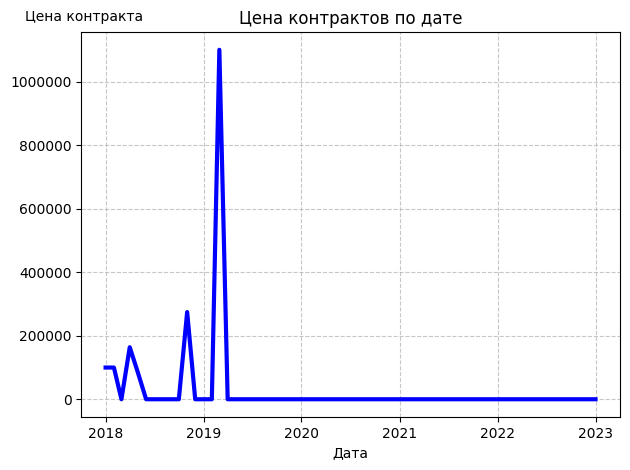

In [90]:
df['contract_date'] = pd.to_datetime(df['contract_date'])
df['contracts_price'] = df['contracts_price'].astype('float')
ax = sns.lineplot(x='contract_date', y='contracts_price', data=df, color='blue', linewidth=3)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.text(0.005, 1.03, 'Цена контракта', transform=ax.transAxes, fontsize=10, ha='center')

plt.title("Цена контрактов по дате")
plt.xlabel('Дата')
plt.ylabel('')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

19:29:12 - cmdstanpy - INFO - Chain [1] start processing
19:29:12 - cmdstanpy - INFO - Chain [1] done processing
/home/ubuntu/lct_hack/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ubuntu/lct_hack/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


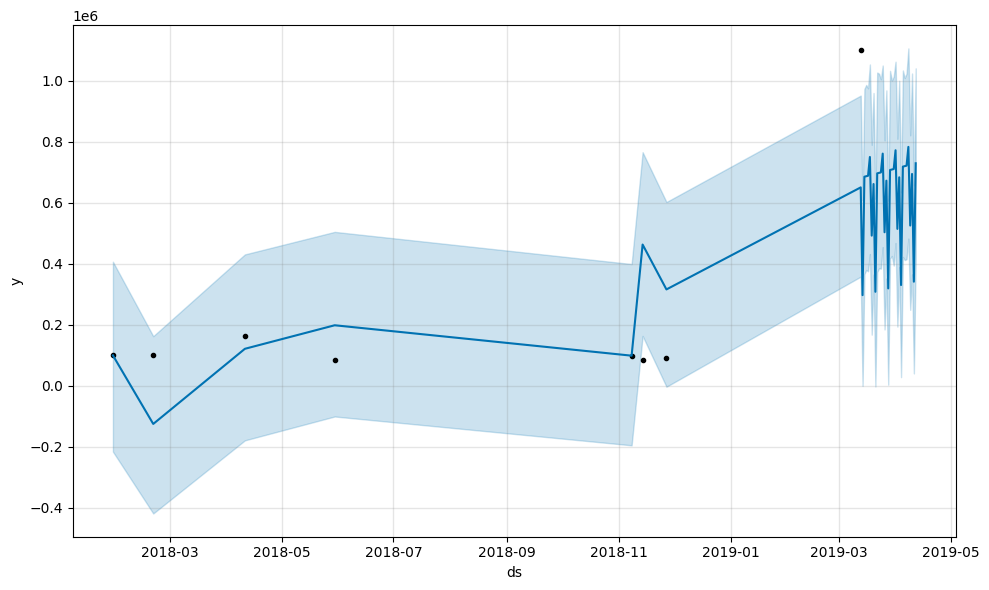

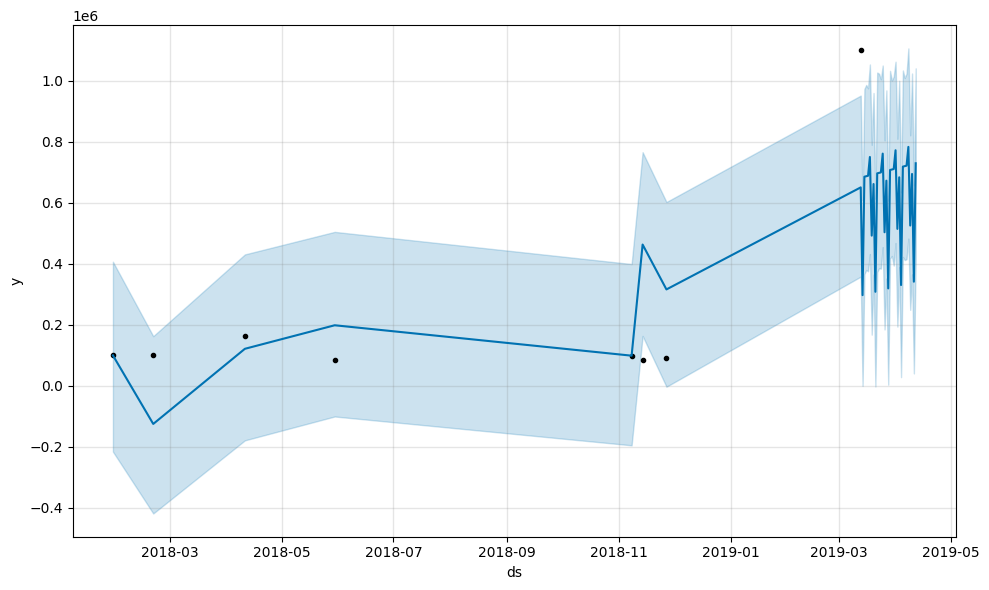

In [26]:
predict_df = df[['contract_date', 'contracts_price']]
predict_df = predict_df.rename(columns={'contract_date': 'ds', 'contracts_price': 'y'})
predict_df['ds'] = pd.to_datetime(predict_df['ds'])
predict_df['y'] = predict_df['y'].astype('float')
m = Prophet()
m.fit(predict_df)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
m.plot(forecast)

<Axes: xlabel='contract_date', ylabel='contracts_price'>

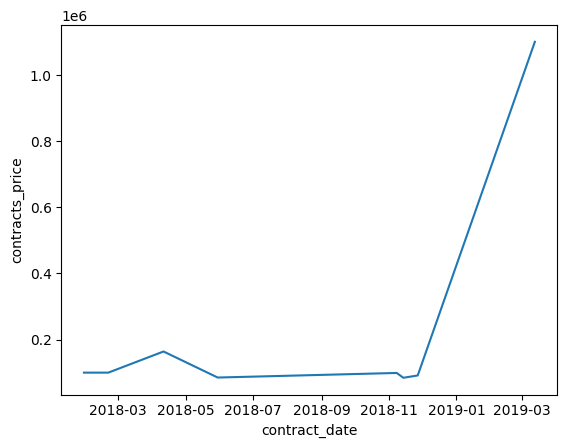

In [7]:
seaborn.lineplot(data=df, x='contract_date', y='contracts_price')